In [ ]:
# |default_exp activations

In [124]:
# |export


import random
from functools import partial

import numpy as np

import torch

import miniai.datasets as ds
import miniai.learner as ln

import fastcore.all as fc

import matplotlib.pyplot as plt

In [125]:
from torch import nn
import torch.nn.functional as F

from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF

import matplotlib as mpl

# Activation stats

To identify how well our models are training we need to be able to look inside and see what is going on. This makes it hard to fix problems or improve things.

## Data

To test what we are going to create.

In [4]:
from datasets import load_dataset

mpl.rcParams["figure.constrained_layout.use"] = True

x_name = "image"
y_name = "label"
dataset_name = "fashion_mnist"
batch_size = 1024

dataset_dict = load_dataset(dataset_name)

In [5]:
@ds.inplace
def transformi(items):
    items[x_name] = [TF.to_tensor(img) for img in items[x_name]]

In [6]:
tdataset_dict = dataset_dict.with_transform(transformi)
dls = ln.DataLoaders.from_dsd(tdataset_dict, batch_size)
train_ds = dls.train

In [7]:
# |export


def set_seed(seed):
    """Set our system up to run in a deterministic matter"""
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

## Model

An example CNN to test our activation stats.

In [8]:
def conv(in_channels, out_channels, kernel_size=2, act=True):
    res = nn.Conv2d(in_channels, out_channels, stride=2, kernel_size=kernel_size, padding=kernel_size // 2)

    if act:
        res = nn.Sequential(res, nn.ReLU())

    return res


def cnn_layers():
    return [  # 28x28
        conv(1, 8, kernel_size=5),  # 14x14
        conv(8, 16),  # 7x7
        conv(16, 32),  # 4x4
        conv(32, 64),  # 2x2
        conv(64, 10, act=False),  # 1x1
        nn.Flatten(),
    ]

In [10]:
metrics = ln.MetricsCB(accuracy=MulticlassAccuracy())
cbs = [ln.TrainCB(), ln.DeviceCB(), metrics, ln.ProgressCB(plot=True)]

We want to train as fast as possible this means at a high learning rate. It also:

* gives a more generalisable set of weights
* training quickly means we can look at each batch less often so helps with overfitting
* a high lr generally means we are learning to train in a stable way

In [27]:
def fit(model, epochs=1, extra_cbs=[]):
    learner = ln.Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, callbacks=cbs + extra_cbs)
    learner.fit(epochs)
    return learner

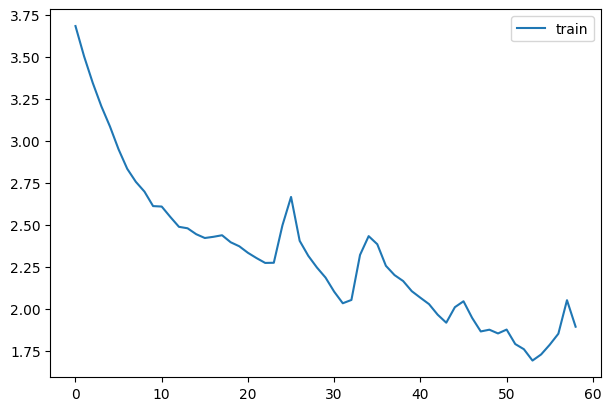

{'epoch': 0, 'train': 'train', 'accuracy': '0.182', 'loss': '2.325'}
{'epoch': 0, 'train': 'eval', 'accuracy': '0.313', 'loss': '1.806'}


In [12]:
set_seed(1)
learner = fit(nn.Sequential(*cnn_layers()))

This went well for a bit but then went a bit wrong lets look inside to find out where it went wrong.

## Hooks

### Manual instertion

We could create our own sequential model like `nn.Sequential` and track the mean and std dev of the weights for each layer of each batch.

In [13]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]

    def __call__(self, inp):
        for idx, layer in enumerate(self.layers):
            inp = layer(inp)

            self.act_means[idx].append(ln.to_cpu(inp).mean())
            self.act_stds[idx].append(ln.to_cpu(inp).std())

        return inp

    def __iter__(self):
        return iter(self.layers)

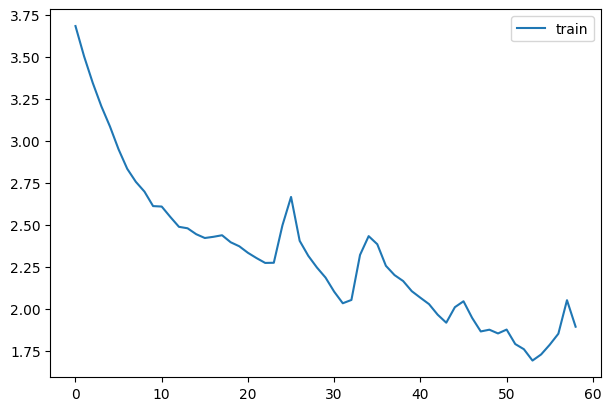

{'epoch': 0, 'train': 'train', 'accuracy': '0.182', 'loss': '2.325'}
{'epoch': 0, 'train': 'eval', 'accuracy': '0.313', 'loss': '1.806'}


In [14]:
# It trains the exact same way
set_seed(1)
model = SequentialModel(*cnn_layers())
learner = fit(model)

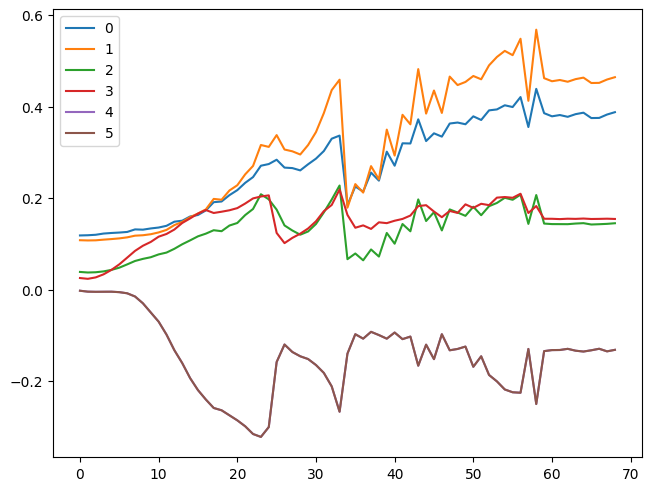

In [15]:
# But we could now plot them (x axis is batch number, y is activation means, color is layer)

for l in model.act_means:
    plt.plot(l)

plt.legend(range(6))

Our activation mean has started small, gone up and then crashed around batch 33 for most layers. When activation means are really close to zero it means that the inputs ot each layer are very close to zero, as a result the outputs are very close to zero as well. So when activation means are close to zero not much happens.

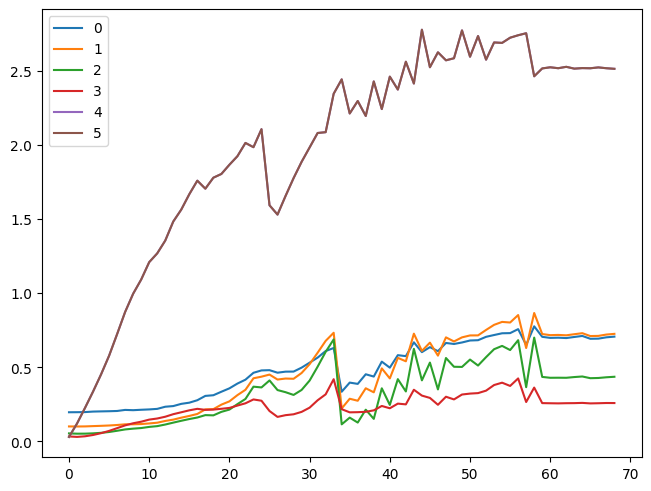

In [16]:
# What about the std devs
for l in model.act_stds:
    plt.plot(l)

plt.legend(range(6))

Generally speaking you want the means of the activations to be about zero and the std dev to be about 1. Mean @ zero is fine as long as they are spread around zero. But a std dev close to zero is terrible as it means all our activations are about the same.

So we can use these two plots to help understand what is going on in our model.

## pytorch hooks

We want to do this in a more elegant way. Hooks can be added to any `nn.Model`, they'll be called when a layer is registered and during the forward and backward passes.

A hook is attached to a layer and has a func that takes 3 args, mdule, input, output.

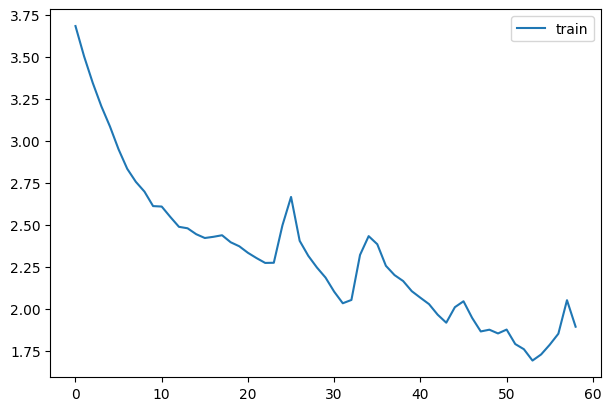

{'epoch': 0, 'train': 'train', 'accuracy': '0.182', 'loss': '2.325'}
{'epoch': 0, 'train': 'eval', 'accuracy': '0.313', 'loss': '1.806'}


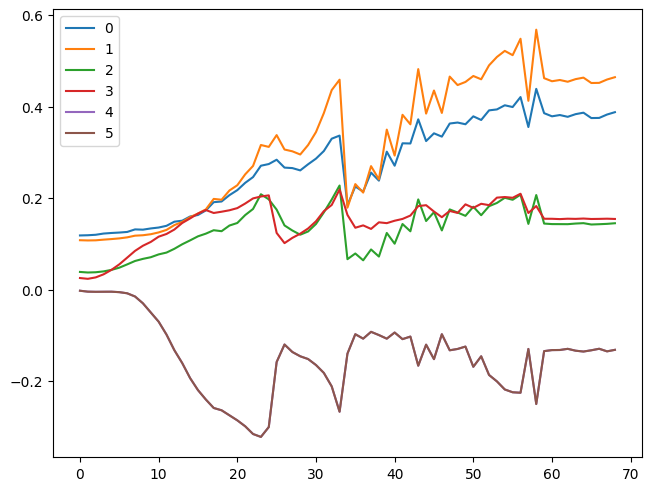

In [17]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

# Store our data here
act_means = [[] for _ in model]
act_stds = [[] for _ in model]


# Our hook
def append_stats(layer_idx, mod, inp, out):
    act_means[layer_idx].append(ln.to_cpu(out).mean())
    act_stds[layer_idx].append(ln.to_cpu(out).std())


# Register the hook on each forwad pass
for idx, layer in enumerate(model):
    layer.register_forward_hook(partial(append_stats, idx))

leaner = fit(model)

for l in act_means:
    plt.plot(l)

plt.legend(range(6))

### Hook class

We can pop this all in a nice hook class to register things on our model for us. I can manage the removal of the hook for use to prevent dangling references.

In [52]:
# |export


class Hook:
    """
    Registers a hook function on a model's forward pass.
    """

    def __init__(self, module, hook_fn):
        self.hook = module.register_forward_hook(partial(hook_fn, self))

    def remove(self):
        self.hook.remove()

    def __del__(self):
        self.remove()

In [53]:
def append_stats(hook, mod, inp, out):
    """Hook function to gets stats (mean, std dev) on fwd pass."""
    if not hasattr(hook, "stats"):
        hook.stats = ([], [])

    acts = ln.to_cpu(out)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

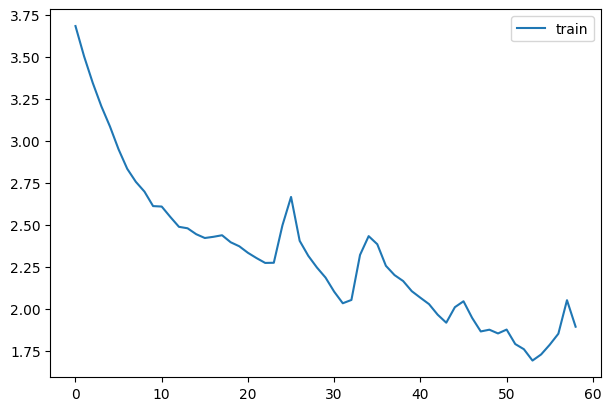

{'epoch': 0, 'train': 'train', 'accuracy': '0.182', 'loss': '2.325'}
{'epoch': 0, 'train': 'eval', 'accuracy': '0.313', 'loss': '1.806'}


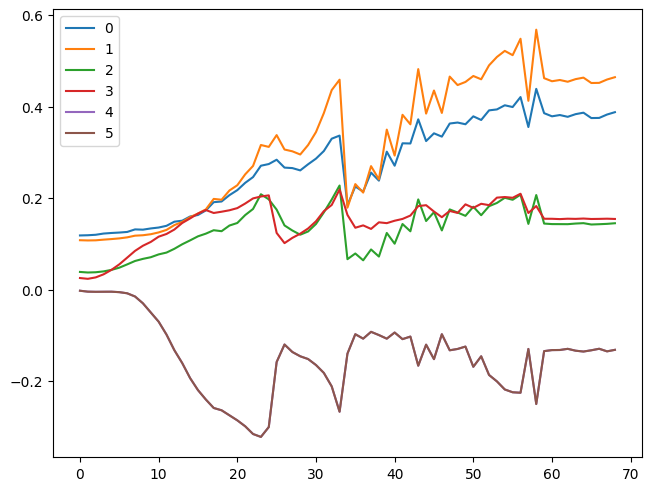

In [19]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hooks = [Hook(layer, append_stats) for layer in model]

leaner = fit(model)

for l in act_means:
    plt.plot(l)
plt.legend(range(6))

### Hooks class

We want to easily manage multiple hooks so we'll use a context manager to help manage their lifetimes. This means we need to use `__enter__` and `__exit__`.

In [20]:
# |export


class Hooks(list):
    """Registers a hook function with a list of modules and manages their lifetime as a context manager."""

    def __init__(self, modules, hook_fn):
        super().__init__([Hook(module, hook_fn) for module in modules])

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.remove()

    def __del__(self):
        self.remove()

    def __delitem__(self, idx):
        self[idx].remove()
        super().__delitem__(idx)

    def remove(self):
        for hook in self:
            hook.remove()

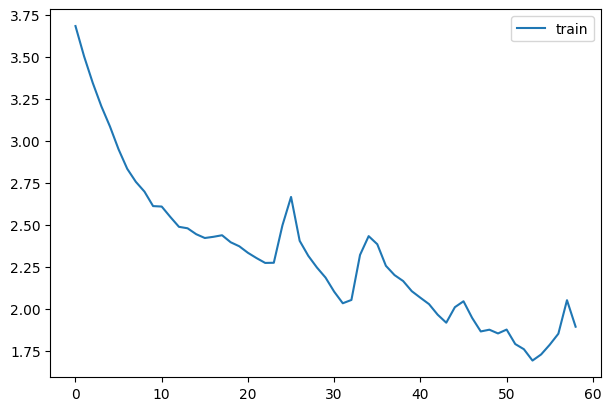

{'epoch': 0, 'train': 'train', 'accuracy': '0.182', 'loss': '2.325'}
{'epoch': 0, 'train': 'eval', 'accuracy': '0.313', 'loss': '1.806'}


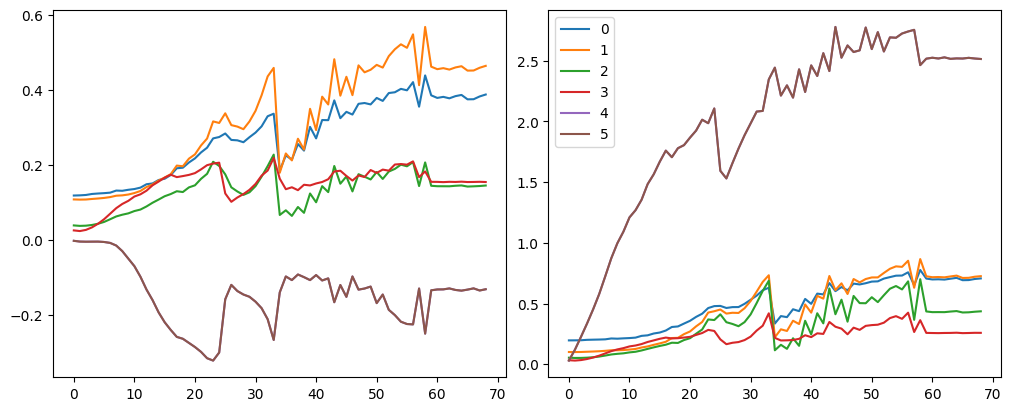

In [29]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

with Hooks(model, append_stats) as hooks:
    learner = fit(model)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for hook in hooks:
        for stat_idx in [0, 1]:
            axes[stat_idx].plot(hook.stats[stat_idx])
    plt.legend(range(6))

### Hooks callback

We can also put all this in a callback for ease of use. Note that this picks up a lot more modules.

In [83]:
# |export


class HooksCB(ln.Callback):
    def __init__(self, hook_fn, mod_filter=fc.noop, on_train=True, on_valid=False):
        fc.store_attr()
        super().__init__()

    def before_fit(self):
        mods = fc.filter_ex(self.learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, self._hook_fn)

    def after_fit(self):
        self.hooks.remove()

    def _hook_fn(self, *args, **kwargs):
        if (self.on_train and self.learn.model.training) or (self.on_valid and not self.learn.model.training):
            self.hook_fn(*args, *kwargs)

    def __iter__(self):
        return iter(self.hooks)

    def __len__(self):
        return len(self.hooks)

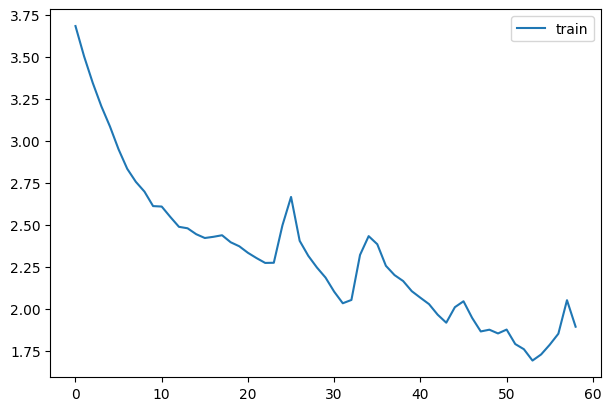

{'epoch': 0, 'train': 'train', 'accuracy': '0.182', 'loss': '2.325'}
{'epoch': 0, 'train': 'eval', 'accuracy': '0.313', 'loss': '1.806'}


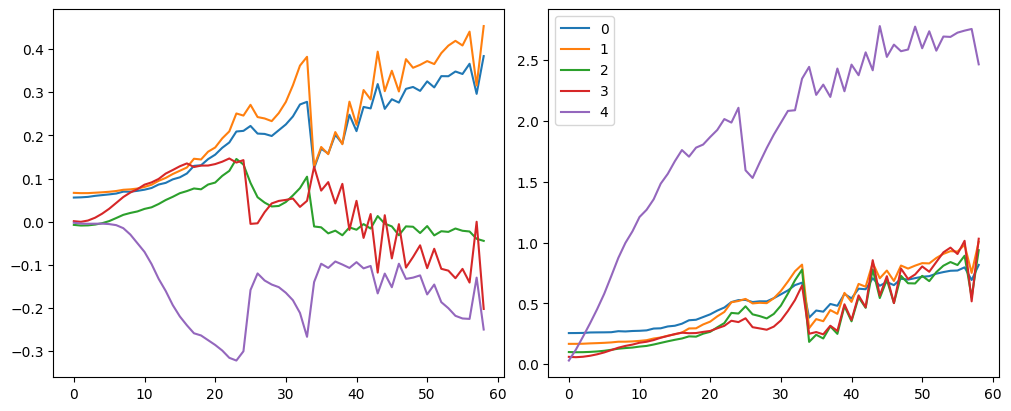

In [86]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
extra_cbs = [HooksCB(append_stats, mod_filter=fc.risinstance(nn.Conv2d))]

learner = fit(model, extra_cbs=extra_cbs)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for hook in extra_cbs[0]:
    for stat_idx in [0, 1]:
        axes[stat_idx].plot(hook.stats[stat_idx])
plt.legend(range(len(extra_cbs[0])))

### Histograms

Lets update append_stats to get us enough info for some histograms.

In [56]:
# |export


def append_stats(hook, mod, inp, out):
    """Hook function to gets stats (mean, std dev, histogram of abs values) on fwd pass."""
    if not hasattr(hook, "stats"):
        hook.stats = ([], [], [])

    acts = ln.to_cpu(out)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40, 0, 10))

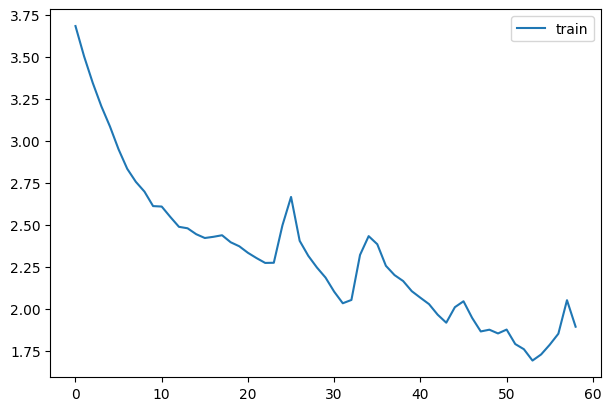

{'epoch': 0, 'train': 'train', 'accuracy': '0.182', 'loss': '2.325'}
{'epoch': 0, 'train': 'eval', 'accuracy': '0.313', 'loss': '1.806'}


In [88]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
extra_cbs = [HooksCB(append_stats, mod_filter=fc.risinstance(nn.Conv2d))]

learner = fit(model, extra_cbs=extra_cbs)

In [79]:
# |export


def get_stats_hist(stats_hook):
    """Get histogram in a suitable format for an image"""
    return torch.stack(stats_hook.stats[2]).t().float().log1p()


def get_stats_hist_min(stats_hook):
    """Get histogram in a suitable format for an image, looking at the smallest equally sized group."""
    hist = torch.stack(stats_hook.stats[2]).t().float()
    return hist[0] / hist.sum(0)

2 2


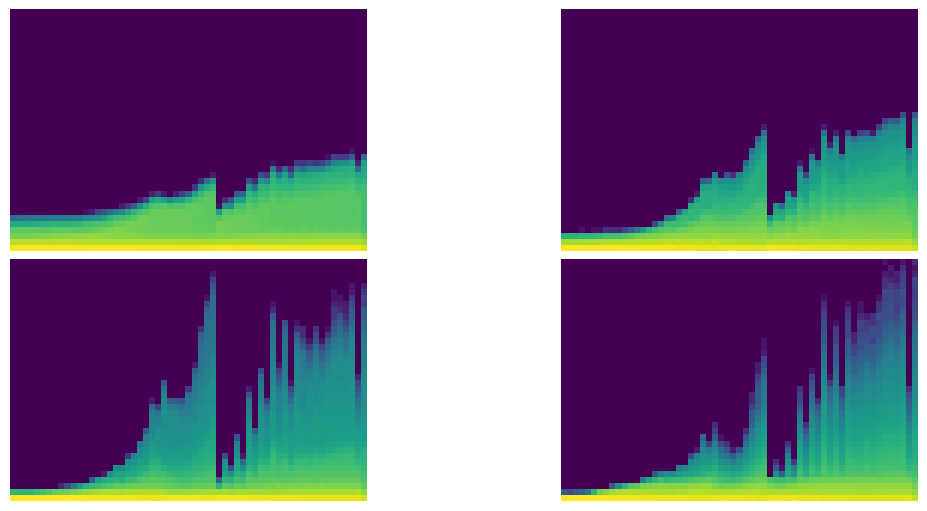

In [89]:
fig, axes = ds.get_grid(len(extra_cbs[0]), figsize=(11, 5))
for ax, h in zip(axes.flat, extra_cbs[0]):
    ds.show_image(get_stats_hist(h), ax, origin="lower")

2 2


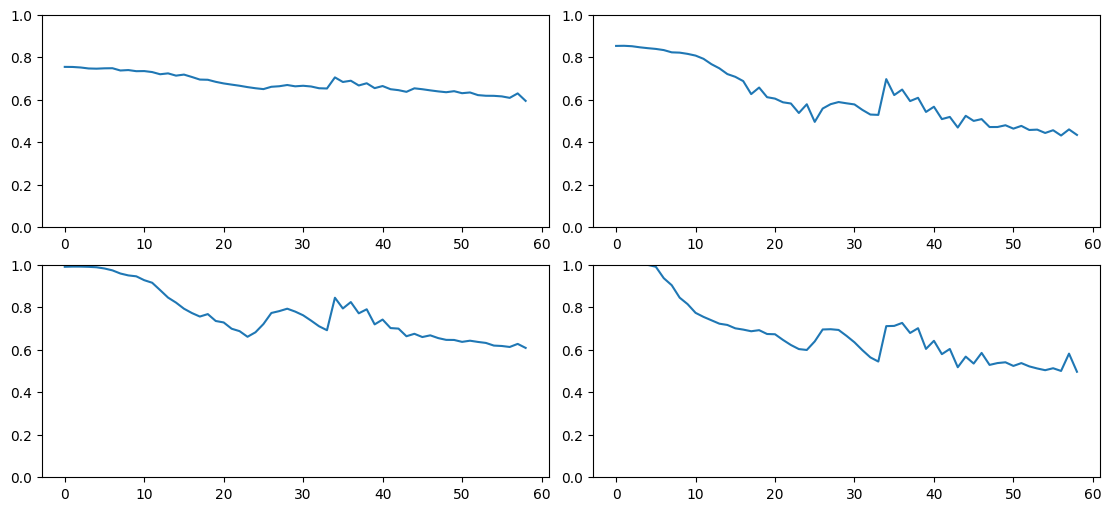

In [91]:
fig, axes = ds.get_grid(len(extra_cbs[0]), figsize=(11, 5))
for ax, h in zip(axes.flatten(), extra_cbs[0]):
    ax.plot(get_stats_hist_min(h))
    ax.set_ylim(0, 1)

So we have a really bad model but at least we can see what is going wrong.

## Activation stats

Lets put this in a single callback.

In [118]:
# |export


class ActivationStatsCB(HooksCB):
    def __init__(self, mod_filter=fc.noop):
        super().__init__(append_stats, mod_filter)

    def plot_stats(self, figsize=(10, 4)):
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        for hook in self:
            for stat_idx in [0, 1]:
                axes[stat_idx].plot(hook.stats[stat_idx])

        axes[0].set_title("Means")
        axes[1].set_title("Std devs")
        plt.legend(range(len(self)))

    def plot_hist(self, figsize=(11, 5)):
        fig, axes = ds.get_grid(len(self), figsize=figsize)
        for axis, hist in zip(axes.flatten(), self):
            ds.show_image(get_stats_hist(hist), axis, origin="lower")

    def plot_dead(self, figsize=(11, 5)):
        fig, axes = ds.get_grid(len(self), figsize=figsize)
        for axis, hist in zip(axes.flatten(), self):
            axis.plot(get_stats_hist_min(hist))
            axis.set_ylim(0, 1)

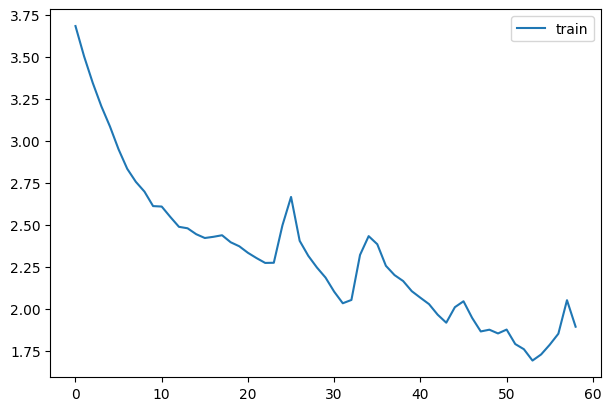

{'epoch': 0, 'train': 'train', 'accuracy': '0.182', 'loss': '2.325'}
{'epoch': 0, 'train': 'eval', 'accuracy': '0.313', 'loss': '1.806'}


In [119]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
stats_cb = ActivationStatsCB(mod_filter=fc.risinstance(nn.Conv2d))

learner = fit(model, extra_cbs=[stats_cb])

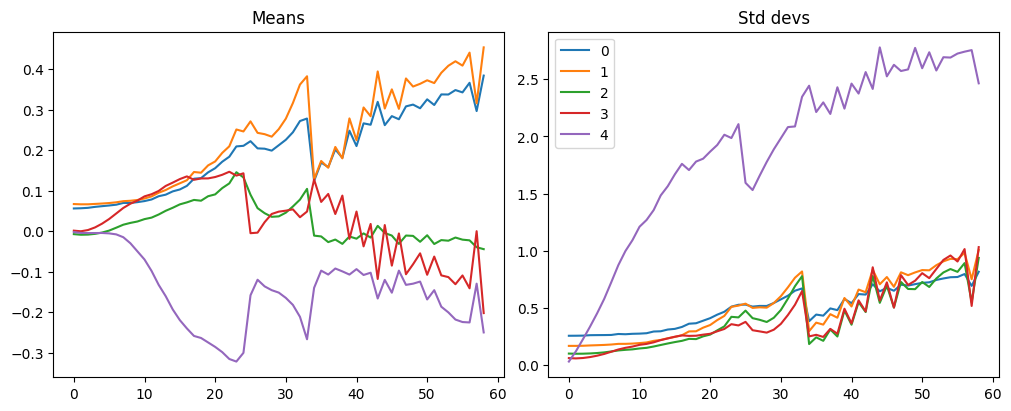

In [120]:
stats_cb.plot_stats()

2 2


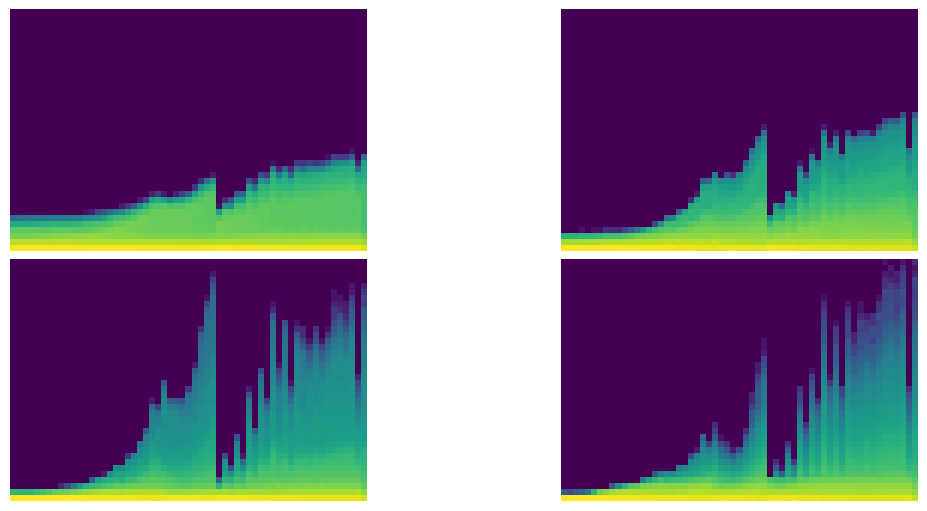

In [121]:
stats_cb.plot_hist()

2 2


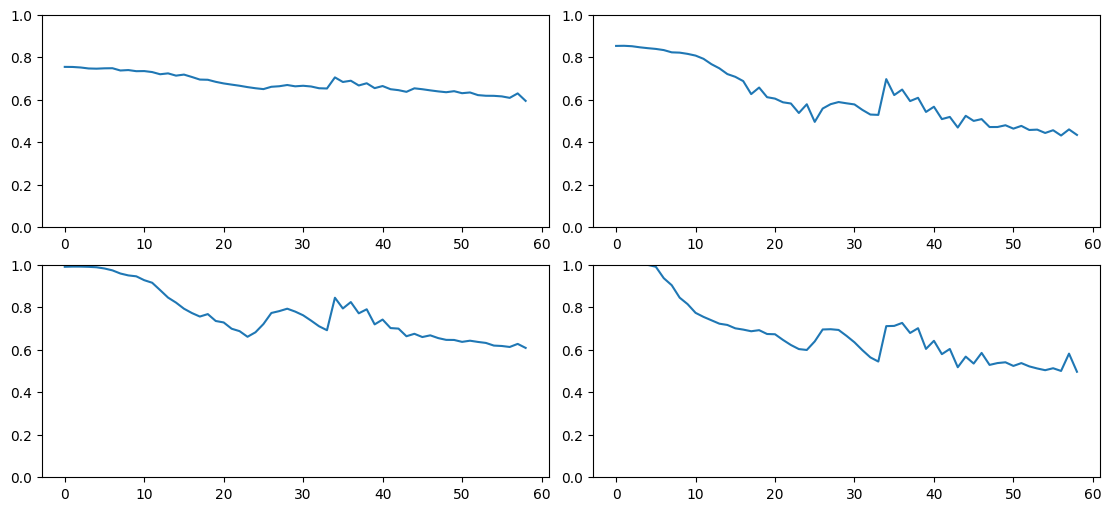

In [123]:
stats_cb.plot_dead()